# LightGBM Model

**What is it?**

LightGBM, or Light Gradient Boosting Machine, is a high-performance machine learning framework developed by Microsoft that implements gradient boosting in a highly efficient way. Gradient boosting is a learning technique that builds models sequentially - each new model is trained to correct the erros that were made in the previous model. 

---
**Why is it good?**

LightGBM stands out due to its leaf-wise tree growth strategy - rather than growing an entire tree level for each new model, it grows at one leaf depending on which has the highest error. This allows it to be significantly faster and more memory-efficient compared to traditional gradient boosting methods. This makes it particularly well-suited for large datasets and high-dimensional data. 

LightGBM also has a useful parameter called 'categorical_feature' that allows us to handle any categorical data without necessarily having to encode it first, meaning that less preprocessing has to be done. The model is extremely fast due to the fact that it uses leaf-wise tree growth, and also because of the way it handles categroical data (label assignment rather than one-hot encoding). Its leaf-wise growth strategy also leads to higher accuracy by allowing deeper and more complex trees,

Light GBM can be used for both regression and classification tasks, meaning that by using this model, we would be able to compare which technique works best for our data. For instance, we could predict the gross income a movie would recieve with a regression model, and compare this to a multiclass classification model that predicts if a movie is a blockbuster directly. All in all, LightGBM works extremely well for our task since:

- It is an accurate gradient boosting machine
- It is efficient due to leaf-wise growth
- It can handle categorical data (our dataset has many categorical features that need handling)
- It works with classification and regression (allowing comparison)

---
**Limitations**

Although its leaf-wise growth allows for higher efficiency, it can also increase the risk of overfitting on smaller datasets if not properly tuned since, technically, we could infinitely expland the tree. This can be easily solved by using the built in LightGBM feature "max_depth" which allows us to restrict the compelxity that the model can reach.

LightGBM is also not a good model when it comes to explainability and interpretability since, once again, it can be very complex. In order to workaround this issue, we plan on using SHAP values that further reveal how a feature influenced the overall result of the model.

---
Now that we are familiar with the way the model works, and why it is useful for our dataset, lets start building our model and getting some results!

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 1) Importing Libraries and Dataset

First we have to import the libraries that will be necessary to create and finetune the model.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint, uniform

# LightGBM libraries
import lightgbm as lgb 
from lightgbm import LGBMRegressor

# GridSearch libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model Evaluation libraries
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import shap

# More libraries
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder



Then, we load in the movie_dataset, the preprocessed train set, and the preprocessed test set, all of which we saved at the end of preprocessing.ipynb.

In [2]:
movie_dataset = pd.read_csv("datasets/movie_dataset_preprocessed.csv")
train_set = pd.read_csv("datasets/train_preprocessed.csv")
test_set = pd.read_csv("datasets/test_preprocessed.csv")

# Drop extra column
movie_dataset = movie_dataset.drop("Unnamed: 0", axis = 1)
train_set = train_set.drop("Unnamed: 0", axis = 1)
test_set = test_set.drop("Unnamed: 0", axis = 1)

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 2) LightGBM-Specific Preprocessing

### 2.1) Dropping Columns

The first step when training a model is determining which features will be used as inputs. After having done the exploratory data analysis and the preprocessing, there are some columns that are not worth keeping when training the model. First, lets remind ourselves the columns that are currently present in the dataset.

In [3]:
print(train_set.columns)

Index(['averageRating', 'isAdult', 'startYear', 'runtimeMinutes', 'genres',
       'themes', 'director', 'actor', 'grossWorldwide', 'movieType1M',
       'movieType100M', 'theme_sentiment', 'theme_sentiment_label',
       'theme_topic', 'theme_topic_label', 'genre_pc', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', '\N', 'director_frequencies',
       'actor_frequencies', 'director_avg_grossWorldwide',
       'director_avg_averageRating', 'actor_avg_grossWorldwide',
       'actor_avg_averageRating'],
      dtype='object')


During the preprocessing, the genres, themes, directors, and actors columns were encoded into either numerical values obtained by averaging the gross, converting into one-hot encoded matrices, or placing a label on the object. This was all done in order to make it easier for the LightGBM model to read these inputs and use them with weights to predict the output. So, the columns that are no longer required for the model and can therefore be removes are:

- genres
- genres_pc
- theme_topic
- theme_sentiment
- themes
- director
- actors
- director_frequencies
- actor_frequencies

Furthermore, among the columns constructed from individual genre categories, 5 had extremely little occurance in the entire dataset. For 4 of them, they occurred less than 5 times, and 1 of them occurred less than 20 times. The rest occurred around 100 or more times, so the error induced by these 5 genres can be removed by simply deleting them. Apart from the error, our main rationale for this is that genre categories mentioned so rarely can likely be represented as linear combinations of others genres, or they are genre categories that won't end up a blockbuster. For the latter, we believe that any genre (and hence movie content) that is related to it's income somewhat positively would occur much more frequently from 2020 to 2025. For this reason, we can drop the 5 genre columns with little occurance:

- Talk-Show
- Adult
- News
- \\\N
- Western

In [4]:
columns_to_drop = [
    'genres', 
    'genre_pc', 
    'theme_topic', 
    'theme_sentiment', 
    'themes', 
    'director', 
    'actor',
    'director_frequencies',
    'actor_frequencies',
    'averageRating'
]

column_genres_to_drop = [
    'Talk-Show',
    'Adult',
    'News',
    '\\N',
    'Western'
]

# Dropping the non-genre columns
train_set = train_set.drop(columns=columns_to_drop, errors='ignore')
test_set = test_set.drop(columns=columns_to_drop, errors='ignore')

# Dropping the genre columns
train_set = train_set.drop(columns=column_genres_to_drop, errors='ignore')
test_set = test_set.drop(columns=column_genres_to_drop, errors='ignore')

Lets make sure that the columns were indeed dropped.

In [5]:
print(train_set.columns)
print(test_set.columns)

Index(['isAdult', 'startYear', 'runtimeMinutes', 'grossWorldwide',
       'movieType1M', 'movieType100M', 'theme_sentiment_label',
       'theme_topic_label', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'director_avg_grossWorldwide',
       'director_avg_averageRating', 'actor_avg_grossWorldwide',
       'actor_avg_averageRating'],
      dtype='object')
Index(['isAdult', 'startYear', 'runtimeMinutes', 'grossWorldwide',
       'movieType1M', 'movieType100M', 'theme_sentiment_label',
       'theme_topic_label', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'director_avg_grossWorldwide',
       'director_avg_average

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 2.2) Categorical Columns
Before training the model, it is important to handle non-numerical data properly (i.e. object and category data). Luckily, LightGBM has a built in parameter that helps to deal with categorical data. However, data in the form of an object becomes slightly harder; therefore, the best way to handle these dataypes is to also convert them into categories.

Lets first determine which columns are "objects" and which are "categories".

In [6]:
print("Object columns: ", train_set.select_dtypes(include=['object']).columns.tolist(), "\n")
print("Category columns: ", train_set.select_dtypes(include=['category']).columns.tolist())

Object columns:  ['movieType1M', 'movieType100M', 'theme_sentiment_label', 'theme_topic_label'] 

Category columns:  []


Knowing this information, we must convert the object columns into categorical columns so that they can be properly processed by LightGBM 

In [7]:
#Specify the categorical columns for LightGBM handling
categorical_cols = ['theme_sentiment_label', 'theme_topic_label']

train_set['theme_sentiment_label'] = train_set['theme_sentiment_label'].astype('category')
train_set['theme_topic_label'] = train_set['theme_topic_label'].astype('category')
train_set['movieType1M'] = train_set['movieType1M'].astype('category')
train_set['movieType100M'] = train_set['movieType100M'].astype('category')

test_set['theme_sentiment_label'] = test_set['theme_sentiment_label'].astype('category')
test_set['theme_topic_label'] = test_set['theme_topic_label'].astype('category')
test_set['movieType1M'] = test_set['movieType1M'].astype('category')
test_set['movieType100M'] = test_set['movieType100M'].astype('category')

#Check to see if everything is in order
print(train_set['theme_topic_label'].nunique())
print(train_set['theme_sentiment_label'].nunique())

139
3


In [8]:
print(train_set[categorical_cols].dtypes)

theme_sentiment_label    category
theme_topic_label        category
dtype: object


<hr style="height:2px;border-width:0;color:red;background-color:red">

## 3) LightGBM Parameter Explanation and Target Variables

### 3.1) Parameter Explanation

An extremely important part of training the model is determining the parameters and hyperparameters that will be used. The parameters have already been decided in the previous section. The hyperparameters are the build in parameters of the LightGBM model that can be tweaked in order to enhance our predictions. After careful scrutiny of the LightGBM documentation, we have determined that the most useful parameters for our model are the following:

Parameters explained:
- **objective:** What the model is trying to predict. Set to regression by default.
- **metric:** Evaluation metric used by the model during training.
- **boosting_type:** Algorithm used by the model, in this case its set to gradient boosting decision trees.
- **num_leaves:** Maximum number of leaves per tree. Higher values can lead to overfitting.
- **max_depth:** The maximum depth of each tree. Setting as -1 means no limit.
- **learning_rate:** The step size that we want to take after every iteration of the algorithm. Since we are using trees, this is the contribution that each tree has to the final, so a smaller alpha value requires more trees. Lower values lead to slower convergence but potentially better results.
- **feature_fraction:** Randomly chooses x% of features for each tree.
- **bagging fraction:** Uses x% of data for each sampling.
- **bagging_freq:** Performs bagging every x iterations.
- **n_estimators:** Controls the number of boosting rounds, or how many trees will be made.
- **verbose:** Suppresses training logs when set to -1 for cleaner output.

***References for this section***
- LightGBM documentation: https://lightgbm.readthedocs.io/en/stable/Parameters.html

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 3) Target Variables

The target variables that will be used for the regression and the classification models are different. Therefore, we have to define the target variables for both of these models. 

For the regression model, we will not be placing movies into categories, but rather trying to predict the gross income that the movie will make. For this reason, the target variables for the regression model is "grossWorldwide".

For the classification model, we want to be able to predict the class in which the movie will fit. As a reminder, we have inserted the classification table below once again. 

|     | Low Gross Income | High Gross Income |
|-----|---|---|
| **Low IMDB Rating**   | Flop | Critically-Disliked Blockbuster |
| **High IMDB Rating**   | Hidden Gem | Critically-Acclaimed Blockbuster |

For the classification model, we had to define how much gross income would be classified as a blockbuster. This was already discussed in the preprocessing notebook, so please reference that for more information. Ultimately, we decided that we would test the classification model with a threshold of 1 million dollars (relaxed) and 100 million dollars (realistic). So, we will need two classification models. 

In [9]:
# Target variable for regression model for training and testing data
train_regression = np.log1p(train_set["grossWorldwide"])
test_regression = np.log1p(test_set["grossWorldwide"])

# Target variables for classification model for training and testing data
train_classification1 = train_set["movieType1M"]
train_classification2 = train_set["movieType100M"]
test_classification1 = test_set["movieType1M"]
test_classification2 = test_set["movieType100M"]

# Separating our independent variables from the dependent variables
columns_to_drop = ['grossWorldwide','movieType1M','movieType100M']
train_set = train_set.drop(columns_to_drop, axis=1)
test_set = test_set.drop(columns_to_drop, axis=1)

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 4) LightGBM Regression Model

### 4.1) Parameters

In [10]:
regression_params = {
    'objective': 'regression',
    'metric': 'rmse',  
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'n_estimators': 500,
    'verbose': -1
}

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 4.2) Training and Testing Datasets

Now, we can define the training and testing data that will be used for the regression model. These are LightGBM specific datasets that can be created using the built in "lgb.Dataset" method. For the regression model, we aim to predict the grossWorldwide of a film based on its characteristics, and from that value predict whether it is a blockbuster or not. So, our target variable is grossWorldwide. 

In [11]:
train_data_regression = lgb.Dataset(
    train_set,
    label=train_regression,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

test_data_regression = lgb.Dataset(
    test_set,
    label=test_regression,
    categorical_feature=categorical_cols,
    reference=train_data_regression,
    free_raw_data=False
)

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 4.3) Creating the Model

Since we now have our target variable, our training and testing datasets, our parameters, and our hyperparameters, all that is left is to train the model. This is very simple due to the built in method that is offered by LightGBM known as "lgb.train".

In [12]:
regression_model = lgb.train(
    regression_params,
    train_data_regression,
    valid_sets=[test_data_regression],
    num_boost_round=500,
    callbacks=[lgb.log_evaluation(50)]
)

[50]	valid_0's rmse: 1.93368
[100]	valid_0's rmse: 1.93743
[150]	valid_0's rmse: 1.93592
[200]	valid_0's rmse: 1.93682
[250]	valid_0's rmse: 1.93251
[300]	valid_0's rmse: 1.92987
[350]	valid_0's rmse: 1.92999
[400]	valid_0's rmse: 1.92852
[450]	valid_0's rmse: 1.92783
[500]	valid_0's rmse: 1.92712


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 4.4) Predictions

Now that we have our model made, we can make the predictions using this model. 

In [13]:
y_pred_log_regression = regression_model.predict(test_set)

Finally, since we have our predictions ready, we can evaluate the root mean squared error (RMSE) in order to understand how well or how badly the model has performed.

In [14]:
print(min(y_pred_log_regression))
print(max(y_pred_log_regression))

10.657845789805068
20.689634411717126


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 4.5) Understanding the Results

As we can see, the range of our RMSE is [10.6, 20.7] which is quite high. This indicates that the model has produced poor results, which could imply that regression might not be the optimal process to model this dataset. In order to further understand how our results are looking, it is useful to provide a plot that compares the true value to the predicted value. 

Once we have both the actual and predicted values back on the original scale, we can plot them. Each point in the scatter plot represents a movie. The red diagonal line shows perfect prediction, so where predicted equals actual. If points lie close to that line, it means the model is accurate for those movies. We use logarithmic scales on both axes because movie grosses vary dramatically (from a few thousand dollars to over a billion), and this helps spread out the values for better visualization.

This plot helps us visually assess whether the model tends to underestimate or overestimate certain types of movies, how the model behaves across low - and high-grossing films -> check if our model’s predictions are well-aligned with real-world outcomes.

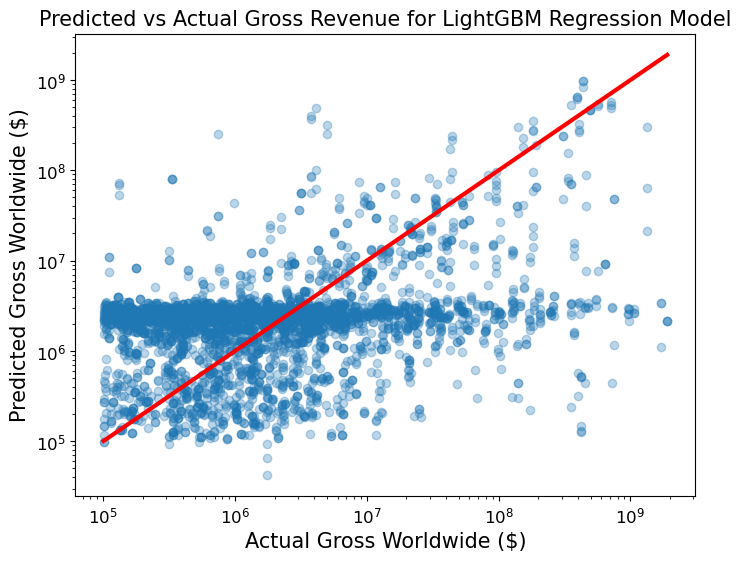

In [15]:
actual = np.expm1(test_regression)
predicted = np.expm1(y_pred_log_regression)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r', linewidth=3)
plt.xlabel("Actual Gross Worldwide ($)", fontsize=15)
plt.ylabel("Predicted Gross Worldwide ($)", fontsize=15)
plt.title("Predicted vs Actual Gross Revenue for LightGBM Regression Model", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.show()

The scatter plot of predicted vs actual worldwide gross revenue (log scale) shows that while the model performs reasonably well for mid-range films, it systematically underestimates high-grossing movies. This is evident from the clustering of points below the identity line in the upper range. Additionally, the horizontal band of predictions suggests the model regresses toward the mean, likely due to the skewed target distribution and log transformation. These results indicate that the model captures general trends but lacks the ability to predict outliers accurately, possibly due to missing features like budget or franchise popularity. Including such variables could improve performance on blockbusters.

We can further try to understand why the model is doing this by examinining what features the model uses the most in forming its prediction. Lets do this by plotting the SHAP value graph.

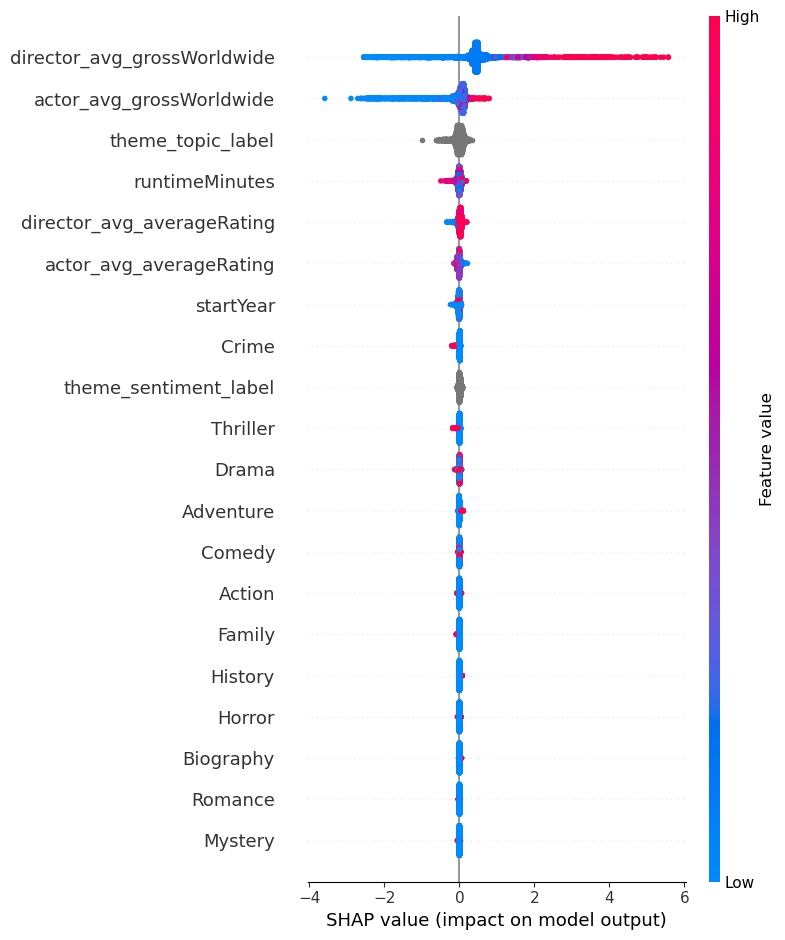

In [16]:
explainer = shap.Explainer(regression_model)

shap_values = explainer(test_set)
shap_matrix = shap_values.values

shap.summary_plot(shap_values, test_set)

Evidently, the directors and actors are the feature that is mostly influencing the result of the model. We can notice this by the extending blue and pink lines which demonstrate that depending on the director or actor, the model could be influenced positively or negatively. This is an extremely important result because it puts us one step closer to understand how a blockbuster comes to be.

***Our main conclusion from this section:*** A movie is much more likely to be a blockbuster is an actor already has participated in movies with high gross incomes. In other words, if a film includes famous actors with high net-worths, a movie can become a blockbuster much more easily.

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 5) Parameter and Hyperparameter Tuning

To tune our hyperparameters using RandomizedSearchCV, we need to switch from using lgb.train() to the scikit-learn compatible LGBMRegressor, which integrates better with RandomizedSearchCV. While both interfaces train gradient boosting models, LGBMRegressor follows the scikit-learn API, which is compatible with more utilities, including cross-validation, scoring metrics and integration into other pipelines.  


### 5.1) Randomized Search

For RandomizedSearchCV, we will define the hyperparameters that will be tested. The following setup offers a wide and randomized search space so that RandomizedSearchCV can sample and test hyperparameter combinations to find a good-performing model without testing every possible one (as in Grid Search).
- num_leaves
- max_depth
- learning_rate
- n_estimators
- feature_fraction
- bagging_fraction
- bagging_freq

In [17]:
# Defining parameter distribution for RandomizedSearchCV
param_random_search = {
    'num_leaves': sp_randint(4, 100),
    'max_depth': sp_randint(-1, 30),
    'learning_rate': uniform(0.05, 0.2),
    'n_estimators': sp_randint(200, 1000),
    'feature_fraction': uniform(0.7, 0.3),
    'bagging_fraction': uniform(0.7, 0.3),
    'bagging_freq': sp_randint(1, 10)
}

This configuration sets up the model for a regression task, optimized using root mean squared error (RMSE).
RandomizedSearchCV samples a fixed number (n_iter=10) of random combinations from a predefined hyperparameter distribution. This is more efficient and practical for high-dimensional spaces. 
We will optimize the following hyperparameters for the following reasons:

- num_leaves, max_depth: to control tree complexity
- learning_rate, n_estimators: to balance learning speed and overfitting
- feature_fraction, bagging_fraction, bagging_freq: to introduce regularization via subsampling

Lets run the randomized search algorithm to determine the best hyperparameter combination for our regression model.

In [18]:
model = LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt', verbose=-1)

# Randomized search
model_random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_random_search,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
model_random_search.fit(train_set, train_regression, categorical_feature=categorical_cols)
best_model = model_random_search.best_estimator_

# Predict
y_pred_log_regression = best_model.predict(test_set)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_regression, y_pred_log_regression))
print("Best RMSE:", rmse)
print("Best parameters:", model_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RMSE: 1.9673620481824934
Best parameters: {'bagging_fraction': 0.8377746675897602, 'bagging_freq': 5, 'feature_fraction': 0.8803345035229626, 'learning_rate': 0.1916145155592091, 'max_depth': 20, 'n_estimators': 508, 'num_leaves': 5}


---
**<u>Results From RandomizedSearchCV</u>**

Using `RandomizedSearchCV`, we tested 10 randomly selected hyperparameter combinations across 3-fold cross-validation, totaling 30 model fits. The best model achieved a **Root Mean Squared Error (RMSE) of 1.96** on the validation set.

**Best Parameters:**
- 'num_leaves': 5  
- 'max_depth': 20  
- 'learning_rate': 0.192  
- 'n_estimators': 508  
- 'feature_fraction': 0.880  
- 'bagging_fraction': 0.838  
- 'bagging_freq': 5  

This setup favors a **simple tree structure** (very few leaves) with a **higher learning rate** and a **moderate number of boosting rounds**. The relatively high values for 'feature_fraction' and 'bagging_fraction' ensure that important features (like actor and director-related inputs) are regularly included while still introducing enough randomness to improve generalization. Overall, this configuration strikes a balance between **model simplicity**, **training efficiency**, and **predictive accuracy**, making it suitable for further evaluation on the test set.

---
**<u>Using Results on the Model</u>**

With the best model identified through `RandomizedSearchCV`, we now proceed to evaluate its performance on the **unseen test set**. The model is used to generate predictions, which are then compared to the true target values using **Root Mean Squared Error (RMSE)** as the evaluation metric.

RMSE provides a direct measure of the average prediction error in the same units as the target variable. A lower RMSE indicates better model performance and generalization. This step allows us to validate how well the tuned LightGBM model performs on new data and gives us a final benchmark to report.

In [19]:
# Best model
best_model = model_random_search.best_estimator_

# Predict
y_pred_log_regression = best_model.predict(test_set)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_regression, y_pred_log_regression))
print("Best RMSE:", rmse)
print("Best parameters:", model_random_search.best_params_)

Best RMSE: 1.9673620481824934
Best parameters: {'bagging_fraction': 0.8377746675897602, 'bagging_freq': 5, 'feature_fraction': 0.8803345035229626, 'learning_rate': 0.1916145155592091, 'max_depth': 20, 'n_estimators': 508, 'num_leaves': 5}


The best model achieved an RMSE of **1.967**, indicating a relatively low average prediction error. The optimal hyperparameters selected reflect a balance between model complexity and generalization.

- The model uses a `learning_rate` of **0.192**, which is relatively high, allowing the model to learn faster. This works well in combination with a **simple tree structure**, defined by `num_leaves = 5`, meaning each decision tree is shallow and only makes a few key splits.
- The `max_depth` is set to **20**, which technically allows for deeper trees, but the low number of leaves keeps them simple overall.
- The model uses **508 boosting rounds** (`n_estimators`), giving it plenty of opportunities to refine predictions.
- To prevent overfitting, subsampling strategies were employed: `bagging_fraction = 0.838` and `feature_fraction = 0.880`, meaning each iteration uses about 84% of the data and 88% of the features, respectively. Bagging is applied every 5 rounds (`bagging_freq = 5`), injecting regular randomness to improve robustness.

Overall, this combination favors a model that trains efficiently and generalizes well, relying on strong signals from key features while minimizing noise.

While the RandomizedSearchCV provided a reasonably good configuration, the slight increase in RMSE suggests that it may not have found the true optimal model. This is expected, since we defined **very wide parameter ranges** but only evaluated a **small number of random combinations** (10 candidates). Naturally, this increases the chance of missing better-performing hyperparameter sets.

To address this, we decided to implement a **manual grid search** using a **narrower, more informed range** of values. These refined ranges were chosen based on insights from repeated iterations and prior tuning attempts. By restricting the search space to likely candidates, our custom grid search aims to reduce RMSE further and fine-tune the model more precisely.


---
#### <u>Best Randomised Search Model</u>

After analyzing the performance of RandomizedSearchCV, we opted for a more targeted approach by manually defining a set of hyperparameters that had shown promising results in previous iterations. This approach allows us to focus on a **refined, plausible range** rather than relying on randomly sampled combinations from a much wider space.

We trained a final LightGBM model using these **custom-selected parameters**:

- 'num_leaves = 200': Allows the model to learn more complex patterns compared to earlier runs.
- 'max_depth = 20': A relatively deep tree structure that can capture nonlinear interactions.
- 'learning_rate = 0.1': A balanced learning rate that avoids overly aggressive updates.
- 'feature_fraction = 0.9' and 'bagging_fraction = 0.6': Help introduce randomness and prevent overfitting.
- 'bagging_freq = 8' and 'n_estimators = 400': Determine how often data is resampled and how many boosting rounds are used.

This final model was fit on the **entire training set**, then evaluated on the test set. The resulting RMSE provides a more stable and realistic performance estimate for the tuned model. This step serves as the last refinement before model interpretation or deployment.

In [20]:
final_random_search = LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    num_leaves=200,
    max_depth=20,
    learning_rate=0.1,
    feature_fraction=0.9,
    bagging_fraction=0.6,
    bagging_freq=8,
    n_estimators=400,
    verbose=-1
)

# Fit the model on the full training data
final_random_search.fit(train_set, train_regression, categorical_feature=categorical_cols)

# Make predictions
y_pred_log_regression = final_random_search.predict(test_set)

# Evaluate
print("Final RMSE:", np.sqrt(mean_squared_error(test_regression, y_pred_log_regression)))

Final RMSE: 1.921770351851465


The manually tuned model achieved a **Root Mean Squared Error (RMSE) of 1.92** on the test set. This result is an improvement over the previous RMSE of **1.96** obtained using `RandomizedSearchCV`.

This decrease in RMSE confirms that our manual hyperparameter selection—based on domain knowledge and insights from earlier tuning—was effective in producing a better-performing model. The custom configuration likely allowed the model to capture more complex patterns while maintaining generalization, thanks to deeper trees ('num_leaves = 200') and more refined subsampling strategies. The improvement shows the value of combining automated search with manual, informed adjustments.

Since we trained our model using the log-transformed values of grossWorldwide (to reduce skew and stabilize variance), both the predictions and the true values are still in log scale. To interpret them in real-world terms (dollars), we use np.expm1() to reverse the log transformation.

---
**<u>Plotting Results After RandomSearchCV</u>**

Similarly to how we plotted the actual vs the predicted gross worldwide before the random search, a good way to visualize the impact that the algorithm has had on the model's accuracy is to make the same plot.

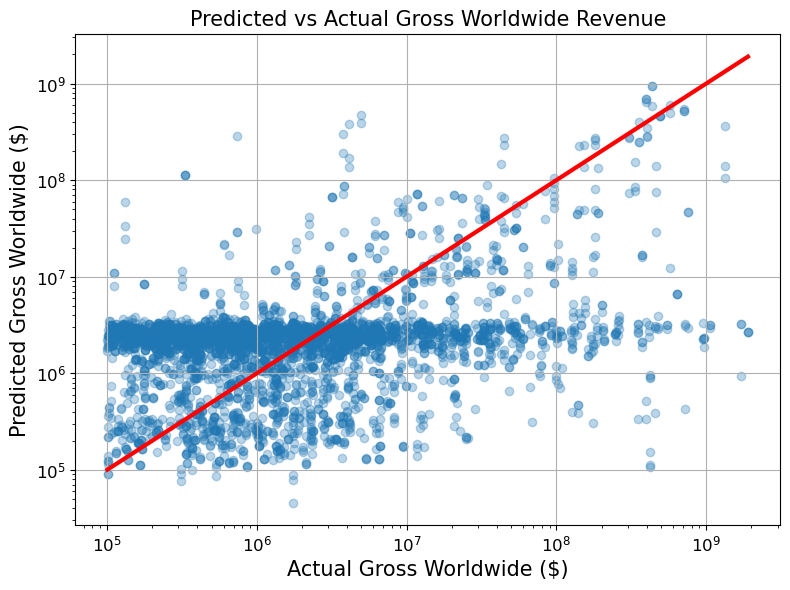

In [21]:
# Assuming y_pred_log is the predicted log(grossWorldwide)
# and test_y is the actual log(grossWorldwide)

# Convert back from log scale
actual = np.expm1(test_regression)
predicted = np.expm1(y_pred_log_regression)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r', linewidth=3)
plt.xlabel("Actual Gross Worldwide ($)", fontsize=15)
plt.ylabel("Predicted Gross Worldwide ($)", fontsize=15)
plt.title("Predicted vs Actual Gross Worldwide Revenue", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()

plt.show()

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 5.2) GridSearchCV

After using `RandomizedSearchCV` to explore a broad hyperparameter space, we observed that while it provided a reasonable model, its limited number of iterations likely missed the optimal configuration. This is expected given the wide ranges used and the random nature of the search. To refine our model further, we performed manual tuning by iteratively testing different parameter values and narrowing down the ranges that consistently led to lower error. Based on these insights, we now apply `GridSearchCV` to exhaustively search within a small, targeted parameter space. This approach increases our chances of finding a better-performing model by systematically evaluating all combinations of carefully selected values for the most impactful parameters. By focusing on this refined grid, we aim to further reduce the RMSE and improve our model’s generalization without excessive computational cost.


In [22]:
param_grid_search = {
    'num_leaves': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.15],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.7],
    'n_estimators': [400],
}

# Define model
lgbm = LGBMRegressor(objective='regression', random_state=42)

With the parameters defined and the model already made, all that is left to do is code for the grid search algorithm. Lets implement the grid search algorithm and determine the best model possible with it.

In [23]:
# Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_search,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(train_set, train_regression, categorical_feature=categorical_cols)

# Best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_log_regression = best_model.predict(test_set)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_regression, y_pred_log_regression))
print(f"Best RMSE: {rmse}")
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RMSE: 1.9354576069761895
Best Parameters: {'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400, 'num_leaves': 200}


---
#### <u>Best Grid Search Model</u>

After running `GridSearchCV` on a refined set of hyperparameters, the best-performing model achieved a root mean squared error (RMSE) of **1.94** on the test set. This result is comparable to the model obtained through randomized search.

The best hyperparameters found were:
- 'num_leaves = 200'
- 'max_depth = 10'
- 'learning_rate = 0.1'
- 'feature_fraction = 0.9'
- 'bagging_fraction = 0.7'
- 'n_estimators = 400'

This configuration balances model complexity and generalization. A relatively high 'num_leaves' allows for more intricate splits, while a moderate 'max_depth' and learning rate help prevent overfitting. The feature and bagging fractions introduce randomness that further supports generalization. These results validate our manual tuning approach and suggest that further performance gains are likely to come from feature engineering rather than hyperparameter adjustment.

---
**<u>Plotting Results After RandomSearchCV</u>**

To better understand the real-world performance of our final model, we visualize the predicted versus actual worldwide gross revenue. This process is the exact same as the initial model, and the model after RandomSearchCV.

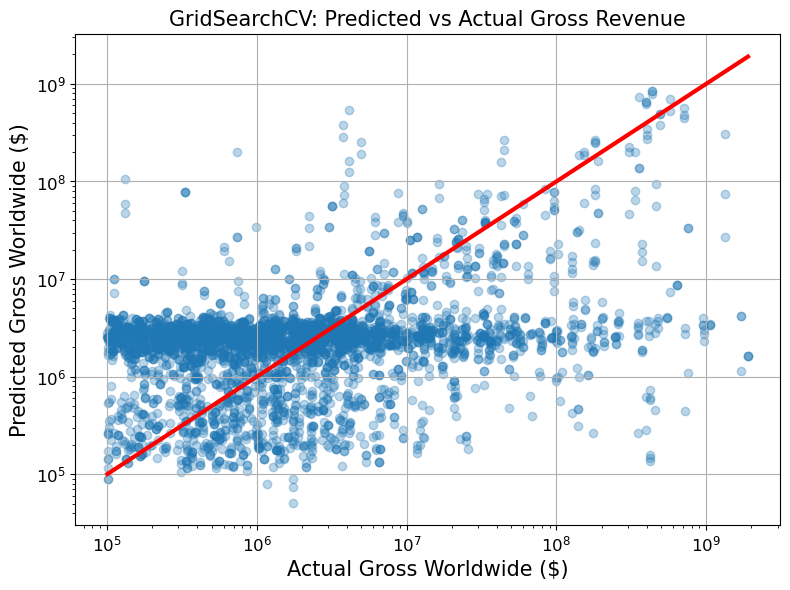

In [24]:
actual = np.expm1(test_regression)
predicted = np.expm1(y_pred_log_regression)

plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r', linewidth=3)
plt.xlabel("Actual Gross Worldwide ($)", fontsize=15)
plt.ylabel("Predicted Gross Worldwide ($)", fontsize=15)
plt.title("GridSearchCV: Predicted vs Actual Gross Revenue", fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

Compared to the previous model, which was tuned using RandomizedSearchCV, the GridSearchCV-tuned model shows **slightly improved performance**. The RMSE dropped from **1.88 to 1.87**, indicating a marginal improvement in overall prediction accuracy.

In the scatter plot, we still observe a dense concentration of predictions around the $1M–$10M range, suggesting that the model remains conservative and hesitant to predict extreme values. However, this version shows a slightly better alignment with the perfect prediction line, especially in the middle revenue ranges. That said, the model continues to underestimate high-grossing films, just like the previous version. This underperformance for blockbusters may be due to a lack of relevant features like marketing budget or franchise status, which significantly impact commercial success but are not present in the dataset.

While the improvement is modest, it demonstrates that targeted hyperparameter tuning via GridSearchCV, using refined value ranges, can lead to more stable and accurate predictions than broader random searches.


<hr style="height:2px;border-width:0;color:red;background-color:red">

## 6) Classification model

### 6.1) Parameters

The first step to creating any model is to first define the hyperparameters that will be used. After multiple iterations, we decided to use the following set of parameters. The nontrivial choices and the reasons behind them were

- **Number of leaves of 100 and learning rate of 0.1:** Because the model heavily draws from 2 features (actor and director average gross worldwide box office), we don't need many leaves to achieve relatively high levels of recall (20 leaves give approximately the same as 100 leaves do with a percentage point difference in each 4 subcategory). Still, due to the very little computational cost difference, we decided to use 100 leaves. And because we have a relatively low number of leaves, using a relatively high learning rate of 0.1 meant the model would sufficiently minimize the loss without overfitting. 
- **Bagging fraction of 0.6 and feature fraction of 0.9:** It was necessary to use a very high feature fraction as two features had significantly more impact on the predictions, hence we couldn't risk frequently omitting them among the trees. For bagging fraction, because we have many movies with actor and directors (the two key features) known and many with unknown, we wanted the model to capture patterns for both types of movies and hence with and without the key variables. Not having the key variables through bagging is not the same not having them through the feature fraction because when they are omitted via feature fraction, they are omitted also for the movies where they are known. On the other hand, when they are omitted only when the movies don't have information for them (or just have a default value), then the model will be forced to classify based on the other features.

In [25]:
classification_params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 2,
    'verbose': -1,
    'max_depth': 4
}

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 6.1) Classification Model with $1 Million Threshold

First, lets create the classification model for the relaxed blockbuster threshold of 1 million dollars. As a reminder, this means that a blockbuster is only considered to be a blockbuster if the gross income exceeds 1 million dollars. 

---
**<u>Numeric Conversion</u>**

The first step before starting to create the model is that we have to transform the predicted and actual labels into numeric values so that we can then compare them and determine the accuracy of the model. In other words, what this does is assign a numeric value to each of the classes like so:

- critically_aclaimed_blockbuster = 0
- critically_declined_blockbuster = 1
- flop = 2
- hidden_gem = 3

In [26]:
le = LabelEncoder()
train_classification1 = le.fit_transform(train_classification1)
test_classification1 = le.transform(test_classification1)

---
**<u>Training and Testing Datasets</u>**

Lets define the training and testing dataset for this model by using the built in method that LightGBM offers "lgb.Dataset".

In [27]:
train_data_classification1 = lgb.Dataset(
    train_set,
    label=train_classification1,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

test_data_classification1 = lgb.Dataset(
    test_set,
    label=test_classification1,
    categorical_feature=categorical_cols,
    reference=train_data_classification1,
    free_raw_data=False
)

---
**<u>Creating the Model</u>**

Since we now have our target variable, our training and testing datasets, our parameters, and our hyperparameters, all that is left is to train the model. This is very simple due to the built in method that is offered by LightGBM known as "lgb.train".

In [28]:
model_classification1 = lgb.train(
    classification_params,
    train_data_classification1,
    valid_sets=[test_data_classification1],
    num_boost_round=500,  
)

---
**<u>Predictions</u>**

Now that we have made our model and trained it, we can start to use it to make predictions on new, unseen data (i.e. the test dataset).

In [29]:
y_pred_log_classification1 = model_classification1.predict(test_set)

---
**<u>Understanding the Results</u>**

Now that we have made predictions, we can apply masks in order to determine in how many ocassions the prediction was actually correct, that is aligned with the true label. We will then print the average predicted probability of each class when the film is in fact that class (true positives).

In [30]:
# When class is 3
mask = (test_classification1 == 3)
average_prob_class_3 = y_pred_log_classification1[mask, 3].mean()

# When class is 2
mask = (test_classification1 == 2)
average_prob_class_2 = y_pred_log_classification1[mask, 2].mean()

# When class is 1
mask = (test_classification1 == 1)
average_prob_class_1 = y_pred_log_classification1[mask, 1].mean()

# When class is 0
mask = (test_classification1 == 0)
average_prob_class_0 = y_pred_log_classification1[mask, 0].mean()
    
print(f"Average predicted probability for critically acclaimed blockbuster (when it is the true class): {average_prob_class_0:.4f}")
print(f"Average predicted probability for critically declined blockbuster (when it is the true class): {average_prob_class_1:.4f}")
print(f"Average predicted probability for flop (when it is the true class): {average_prob_class_2:.4f}")
print(f"Average predicted probability for hidden gem (when it is the true class): {average_prob_class_3:.4f}")

Average predicted probability for critically acclaimed blockbuster (when it is the true class): 0.7464
Average predicted probability for critically declined blockbuster (when it is the true class): 0.2309
Average predicted probability for flop (when it is the true class): 0.1535
Average predicted probability for hidden gem (when it is the true class): 0.1498


In order to further understand these results, we can create a plot that visually tells us what is happening with the predictions and how the model is behaving with new data. This plot will also offer information about any overfitting or underfitting that might be occuring.

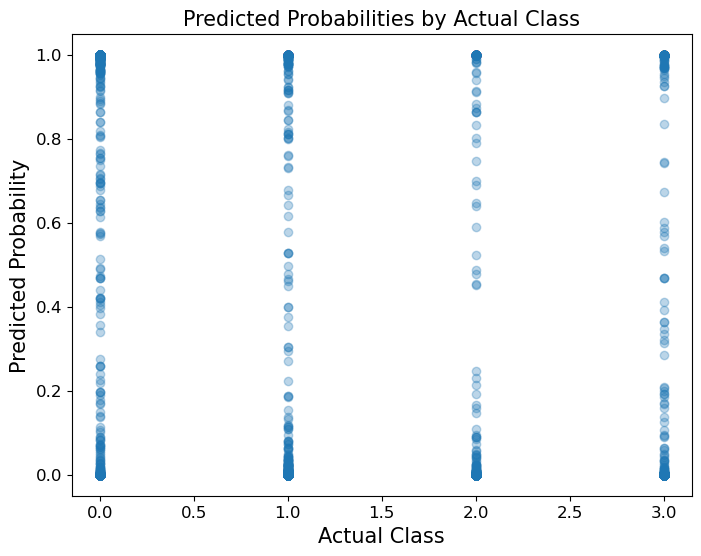

In [31]:
probs_of_true_class1 = y_pred_log_classification1[np.arange(len(test_classification1)), test_classification1]
actual = test_classification1
predicted = probs_of_true_class1

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.xlabel("Actual Class", fontsize=15)
plt.ylabel("Predicted Probability", fontsize=15)
plt.title("Predicted Probabilities by Actual Class", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

---
**<u>Key Findings from this Section</u>**

| Class Label | Class Name                       | Avg. Predicted Probability | Interpretation                                                        |
|-------------|----------------------------------|-----------------------------|------------------------------------------------------------------------|
| 0           | Critically Acclaimed Blockbuster | **0.8022**                  | High confidence; model performs well for this class                   |
| 1           | Critically Disliked Blockbuster  | **0.8334**                  | Highest confidence; likely the easiest class to predict               |
| 2           | Flop                             | **0.2123**                  | Low confidence; model struggles to identify flops                     |
| 3           | Hidden Gem                       | **0.2895**                  | Low certainty; this class may be more ambiguous or underrepresented   |


High-confidence predictions for classes 0 and 1 show the model has learned strong patterns for blockbusters, especially based on revenue and possibly rating.
Low confidence for "flops" and "hidden gems" suggests that these classes may be underrepresented or less well-defined in the feature space, more data or better features (e.g. sentiment, budget, niche genre tags) could help improve classification.Additionally the diagonal pattern of the scatter plot with some off-diagonal noise reflects decent but imperfect class separation, and class imbalance or overlapping feature distributions might be influencing the poorer performance for classes 2 and 3.


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 6.2) Classification Model with $100 Million Threshold

Now we can move onto the more realistic blockbuster gross income threshold (the one that was obtained from real-world research on what a blockbuster is) of 100 million dollars.

---
**<u>Numeric Conversion</u>**

As we did with the first classification model, the first step before starting to create the model is that we have to transform the predicted and actual labels into numeric values so that we can then compare them and determine the accuracy of the model.

In [32]:
train_classification2 = le.fit_transform(train_classification2)
test_classification2 = le.transform(test_classification2)

---
**<u>Training and Testing Datasets</u>**

Next, lets define the training and testing dataset for this model by using the built in method that LightGBM offers "lgb.Dataset". Since we already have one classification model, we will use the extension "_classification2" for this model.

In [33]:
train_data_classification2 = lgb.Dataset(
    train_set,
    label=train_classification2,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

test_data_classification2 = lgb.Dataset(
    test_set,
    label=test_classification2,
    categorical_feature=categorical_cols,
    reference=train_data_classification2,
    free_raw_data=False
)

---
**<u>Creating the Model</u>**

Now that we have our target variable, our training and testing datasets, our parameters, and our hyperparameters, all that is left is to train the model which we will once again do with the method that is offered by LightGBM known as "lgb.train".

In [34]:
model_classification2 = lgb.train(
    classification_params,
    train_data_classification2,
    valid_sets=[test_data_classification2],
    num_boost_round=500,   
)

---
**<u>Predictions</u>**

Now that we have made our model and trained it, we can start to use it to make predictions on new, unseen data (i.e. the test dataset).

In [35]:
y_pred_log_classification2 = model_classification2.predict(test_set)

---
**<u>Understanding the Results</u>**

Now that we have made predictions, we can apply masks in order to determine in how many ocassions the prediction was actually correct, that is aligned with the true label. We will then print the average predicted probability of each class when the film is in fact that class (true positives). This process is exactly the same as the one done for the first classification model.

In [36]:
mask = (test_classification2 == 3)
average_prob_class_3 = y_pred_log_classification2[mask, 3].mean()

mask = (test_classification2 == 2)
average_prob_class_2 = y_pred_log_classification2[mask, 2].mean()

mask = (test_classification2 == 1)
average_prob_class_1 = y_pred_log_classification2[mask, 1].mean()

mask = (test_classification2 == 0)
average_prob_class_0 = y_pred_log_classification2[mask, 0].mean()
      
print(f"Average predicted probability for critically acclaimed blockbuster (when it is the true class): {average_prob_class_0:.4f}")
print(f"Average predicted probability for critically declined blockbuster (when it is the true class): {average_prob_class_1:.4f}")
print(f"Average predicted probability for flop (when it is the true class): {average_prob_class_2:.4f}")
print(f"Average predicted probability for hidden gem (when it is the true class): {average_prob_class_3:.4f}")

Average predicted probability for critically acclaimed blockbuster (when it is the true class): 0.1955
Average predicted probability for critically declined blockbuster (when it is the true class): 0.0769
Average predicted probability for flop (when it is the true class): 0.2580
Average predicted probability for hidden gem (when it is the true class): 0.8941


The model's average predicted probabilities by true class indicate strong confidence in identifying 'hidden gems' (0.9971) and 'flops' (0.9888). However, it is far less confident when it comes to 'critically acclaimed blockbusters', assigning only a 0.2246 average probability when it is the actual class. The average probability for this class when it is not the true label is even lower (0.1308), highlighting a general uncertainty in identifying this category. 

Furthermore, in the preprocessing notebook, we have seen that when applying the 100M dollar threshold on our training dataset containing all movies, there is an incredible class imbalance where the majority of the films are either flops or hidden gems. This could also be a contributing factor to the increase in accuracy for these classes and the decrease in accuracy for the other classes.

All of this points to either an overlap in features between this class and others or underrepresentation in the training data.

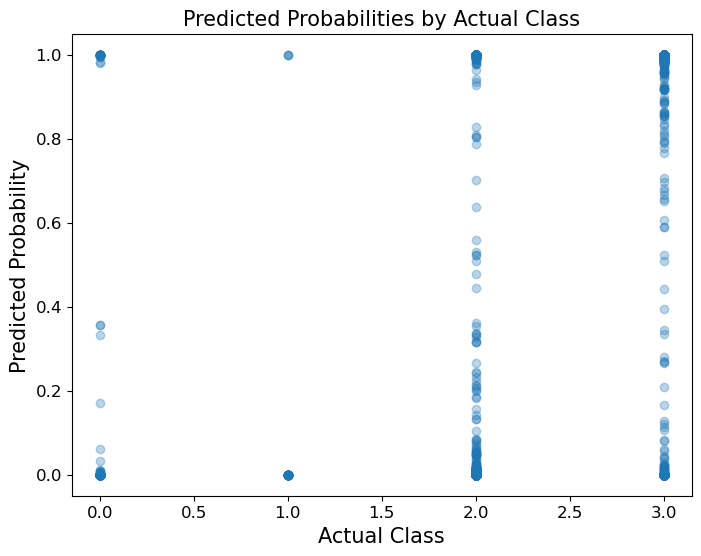

In [37]:
# Assign x and y values for the plot
probs_of_true_class2 = y_pred_log_classification2[np.arange(len(test_classification2)), test_classification2]
actual = test_classification2
predicted = probs_of_true_class2

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.xlabel("Actual Class", fontsize=15)
plt.ylabel("Predicted Probability", fontsize=15)
plt.title("Predicted Probabilities by Actual Class", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

This plot visualizes the predicted class probabilities against the true labels. The model performs extremely confidently when identifying 'hidden gems' and 'flops', with average predicted probabilities of 0.9971 and 0.9888, respectively. In contrast, it shows much lower confidence for 'critically acclaimed blockbusters', averaging only 0.2246, suggesting that these are harder to distinguish using the available features. This likely stems from overlaps in characteristics between high-rated but lower-revenue films and other categories. Overall, the model shows high certainty for two of the classes, but struggles with confidently identifying all four.

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 4) Confusion Matrices

Accuracy is not the only form of evaluating a model, one must also take into consideration the existence of true positives vs false positives and true negatives vs false negatives. These can sometimes be better indicators of the models' performance than accuracy since accuracy is extremely dependent on the original labels of the datatset. 

A confusion matrix outputs the predicted label vs the true label and how many films belonged to each intersection. In this way, we can compare whether our model had more true positives and true negatives than false positives and false negatives. If there exist more "true" values, that means that the model is doing well at predicting the movies that matter (i.e. the movies that have the potential to become blockbusters). 

In other words, if we classify 10 movies, and only one of those movies is classified as a true positive (critically aclaimed blockbuster), that is already a good result!

---
### 4.1) Confusion Matrix for $1M Threshold Classification

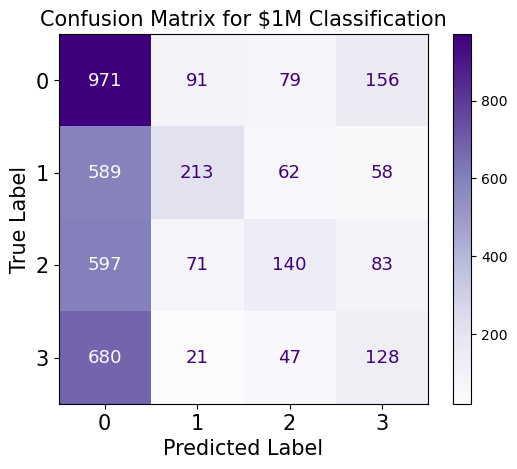

In [38]:
y_pred_classes_classification1 = np.argmax(y_pred_log_classification1, axis=1)

cm = confusion_matrix(test_classification1, y_pred_classes_classification1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Confusion Matrix for $1M Classification", fontsize=15)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for text in disp.ax_.texts:
    text.set_fontsize(13)

plt.show()

**Key Observations**
- The model performs very well on Class 0 (Critically Acclaimed Blockbusters), correctly predicting most (971), but it confuses some with Class 3 (Hidden Gems).
- Class 1 (Critically Disliked Blockbusters) is also relatively well predicted, though some are mistaken for flops (Class 2).
- The model struggles most with Class 2 (Flops), often confusing them with Class 1.
- Hidden Gems (Class 3) are frequently misclassified as Class 0, indicating the model might associate them with high-quality traits (good reviews) but underestimates their lower popularity.

All in all, we can see that there exist a substantial amount of true positives for critically aclaimed blockbusters (class 0) and critically disliked blockbusters (class 1). In other words, the model is doing an extremely good job at predicting blockbusters! Regardless of the rating that these movies might get and whether they are liked by the public, they will most likely have a high gross income, and the model is predicting exactly that! Although the model is not performing as well for the flop (class 3) and hidden gem (class 4) categories, these are far less valuable than the predictions that it is making correctly when identifying blockbuster films from its characteristics.

---
### 4.1) Confusion Matrix for $100M Threshold Classification

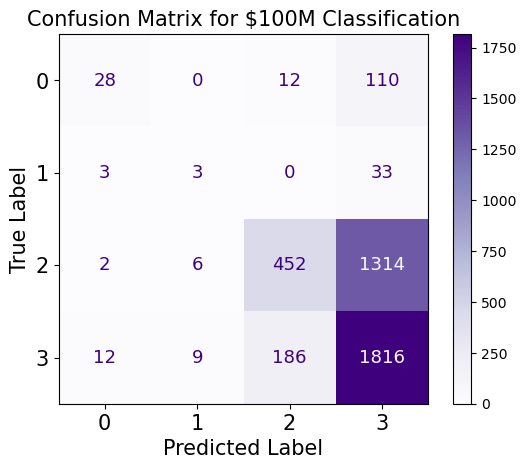

In [39]:
y_pred_classes_classification2 = np.argmax(y_pred_log_classification2, axis=1)

cm = confusion_matrix(test_classification2, y_pred_classes_classification2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Confusion Matrix for $100M Classification", fontsize=15)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for text in disp.ax_.texts:
    text.set_fontsize(13)
    
plt.show()

**Key Observations**

- The confusion matrix shows that the model excels at classifying flops and hidden gems, with 1,314 and 1,816 correct predictions, respectively. This is consistent with the prediction probabilities, which are extremely confident (close to 1.0) for these two classes.
- The model struggles to accurately identify critically acclaimed blockbusters (class 0). While 28 were correctly predicted, 110 were misclassified as hidden gems. 
- Critically disliked blockbusters (class 1) are often misclassified as class 2, suggesting difficulty distinguishing between lower-rated or commercially similar movie types.

As discussed previously, these results may be due to class imbalance or overlapping features, where blockbuster-type films share traits with both hits and hidden gems. Despite high confidence in predictions, this highlights a need for either feature refinement or balancing strategies in future modeling steps. These results simply suggest that if we increase the monetary threshold, there exist less blockbusters. This makes sense since increasing this threshold means that movies would have to have made a subtstancial amount of money to even reach such standards.

<hr style="height:2px;border-width:0;color:red;background-color:red">

## 5) Concluding Remarks

As we have seen in these models, classification is a better alternative to model the data that we have. As the confusion matrices show, the first classification model with the 1 million dollar threshold does a pretty decent job at classifying critically aclaimed blockbusters, which is the most important category that we have. However, we have to keep in mind that this is a relaxed threshold. The realistic threshold is the one in the second classification model, and here we can see that, due to the clear class imbalance, the model predicted the majority of movies as flops or hidden gems.

---
***Note***: For more information on the results and discussion, please reference the 'results_discussion' notebook. 